# Emoji generator using GAN.
Addapted from Keras Minimal Viable GAN

In [1]:
import csv
import imageio
import os
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Image
from tqdm import tqdm  # performance timing

# Building on Keras
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import fashion_mnist
from keras.optimizers import Adam
from keras import initializers
from skimage import color

np.random.seed(10)
random_dim = 100


Using TensorFlow backend.


In [2]:
emojis = np.array([imageio.imread(os.path.join('final_emoji/', emoji)) 
                   for emoji in os.listdir('final_emoji/')])


In [3]:
emojis = emojis / 255

In [4]:
emojis.shape

(976, 36, 36, 3)

In [5]:
emojis = np.array([emoji.flatten() for emoji in emojis])

In [6]:
emojis.shape

(976, 3888)

In [14]:
def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(
        1024, input_dim=3888,
        kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
 
    discriminator.add(Dense(1024))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
 
    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
 
    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(
        256, input_dim=random_dim,
        kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))
 
    generator.add(Dense(524))
    generator.add(LeakyReLU(0.2))
 
    generator.add(Dense(1048))
    generator.add(LeakyReLU(0.2))
 
    generator.add(Dense(3888, activation='sigmoid'))
    generator.compile(loss='categorical_crossentropy', optimizer=optimizer)
    return generator

def get_gan_network(discriminator, random_dim, generator, optimizer):
    # We initially set trainable to False since we only want to train either the 
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real/not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan



In [15]:
 def plot_generated_images(epoch, generator, examples=100, dim=(10, 10),
                           figsize=(15, 15)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 36, 36, 3)
 
    plt.figure(figsize=figsize)
    for i in range(10):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow((generated_images[i] * 255).astype(np.uint8), interpolation='nearest')
        plt.axis('off')
        # plt.title(f'epoch: {epoch}')
    plt.tight_layout()
    if epoch == 25000:
        plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

In [26]:
def train(x_train, epochs=1, batch_size=128):
    # Get the training and testing data
    # x_train, y_train, x_test, y_test = load_minst_data()
    # Split the training data into batches of size 128
    batch_count = x_train.shape[0] // batch_size
 
    # Build our GAN netowrk
    adam = Adam(lr=0.0002, beta_1=0.5)
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)
    
    # Pre-train generator and discriminator.
    for e in tqdm(range(1, epochs + 1)):
        # Generator.
        noise = np.random.normal(0, 1, size=[batch_size, random_dim])
        image_batch = x_train[np.random.randint(0, x_train.shape[0],
                                               size=batch_size).flatten()]
        generator.train_on_batch(noise, image_batch)
        
        # Discriminator.
        noise = np.random.normal(0, 1, size=[batch_size, 3888])
        image_batch = x_train[np.random.randint(0, x_train.shape[0],
                                                size=batch_size)]
        y_dis = np.zeros(2 * batch_size)
        y_dis[:batch_size] = 0.9
        X = np.concatenate([image_batch, noise])
        discriminator.trainable = True
        discriminator.train_on_batch(X, y_dis)
    
    
 
    for e in tqdm(range(1, epochs + 1)):
#         print (f"{'-' * 15}, 'Epoch {e}, {'-' * 15}")
        for _ in range(batch_count):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0],
                                                    size=batch_size)]
 
            # Generate fake images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])
 
            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9
 
            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)
 
            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)
 
        if e % 1000 == 0:
            plot_generated_images(e, generator)
    return generator

In [27]:
epochs = 250

In [28]:
generator = train(emojis, epochs, 64)

  0%|          | 0/250 [00:00<?, ?it/s]

---------------, 'Epoch 1, ---------------


  0%|          | 1/250 [00:13<54:25, 13.12s/it]

---------------, 'Epoch 2, ---------------


  1%|          | 2/250 [00:21<48:51, 11.82s/it]

---------------, 'Epoch 3, ---------------


  1%|          | 3/250 [00:31<45:19, 11.01s/it]

---------------, 'Epoch 4, ---------------


  2%|▏         | 4/250 [00:41<43:51, 10.70s/it]

---------------, 'Epoch 5, ---------------


  2%|▏         | 5/250 [00:50<42:44, 10.47s/it]

---------------, 'Epoch 6, ---------------


  2%|▏         | 6/250 [01:00<41:13, 10.14s/it]

---------------, 'Epoch 7, ---------------


  3%|▎         | 7/250 [01:09<39:26,  9.74s/it]

---------------, 'Epoch 8, ---------------


  3%|▎         | 8/250 [01:17<38:08,  9.46s/it]

---------------, 'Epoch 9, ---------------


  4%|▎         | 9/250 [01:26<37:28,  9.33s/it]

---------------, 'Epoch 10, ---------------


  4%|▍         | 10/250 [01:35<36:45,  9.19s/it]

---------------, 'Epoch 11, ---------------


  4%|▍         | 11/250 [01:44<36:05,  9.06s/it]

---------------, 'Epoch 12, ---------------


  5%|▍         | 12/250 [01:53<35:57,  9.07s/it]

---------------, 'Epoch 13, ---------------


  5%|▌         | 13/250 [02:02<35:52,  9.08s/it]

---------------, 'Epoch 14, ---------------


  6%|▌         | 14/250 [02:12<36:03,  9.17s/it]

---------------, 'Epoch 15, ---------------


  6%|▌         | 15/250 [02:20<35:25,  9.04s/it]

---------------, 'Epoch 16, ---------------


  6%|▋         | 16/250 [02:29<35:11,  9.02s/it]

---------------, 'Epoch 17, ---------------


  7%|▋         | 17/250 [02:38<34:59,  9.01s/it]

---------------, 'Epoch 18, ---------------


  7%|▋         | 18/250 [02:48<35:08,  9.09s/it]

---------------, 'Epoch 19, ---------------


  8%|▊         | 19/250 [02:57<34:59,  9.09s/it]

---------------, 'Epoch 20, ---------------


  8%|▊         | 20/250 [03:06<34:39,  9.04s/it]

---------------, 'Epoch 21, ---------------


  8%|▊         | 21/250 [03:14<34:18,  8.99s/it]

---------------, 'Epoch 22, ---------------


  9%|▉         | 22/250 [03:23<34:10,  8.99s/it]

---------------, 'Epoch 23, ---------------


  9%|▉         | 23/250 [03:32<33:39,  8.90s/it]

---------------, 'Epoch 24, ---------------


 10%|▉         | 24/250 [03:41<33:33,  8.91s/it]

---------------, 'Epoch 25, ---------------


 10%|█         | 25/250 [03:50<33:27,  8.92s/it]

---------------, 'Epoch 26, ---------------


 10%|█         | 26/250 [03:59<33:27,  8.96s/it]

---------------, 'Epoch 27, ---------------


 11%|█         | 27/250 [04:11<36:09,  9.73s/it]

---------------, 'Epoch 28, ---------------


 11%|█         | 28/250 [04:21<36:11,  9.78s/it]

---------------, 'Epoch 29, ---------------


 12%|█▏        | 29/250 [04:30<36:13,  9.84s/it]

---------------, 'Epoch 30, ---------------


 12%|█▏        | 30/250 [04:40<35:11,  9.60s/it]

---------------, 'Epoch 31, ---------------


 12%|█▏        | 31/250 [04:49<34:45,  9.52s/it]

---------------, 'Epoch 32, ---------------


 13%|█▎        | 32/250 [04:58<34:13,  9.42s/it]

---------------, 'Epoch 33, ---------------


 13%|█▎        | 33/250 [05:07<33:24,  9.24s/it]

---------------, 'Epoch 34, ---------------


 14%|█▎        | 34/250 [05:16<32:52,  9.13s/it]

---------------, 'Epoch 35, ---------------


 14%|█▍        | 35/250 [05:25<32:34,  9.09s/it]

---------------, 'Epoch 36, ---------------


 14%|█▍        | 36/250 [05:34<32:13,  9.03s/it]

---------------, 'Epoch 37, ---------------


 15%|█▍        | 37/250 [05:42<31:50,  8.97s/it]

---------------, 'Epoch 38, ---------------


 15%|█▌        | 38/250 [05:51<31:36,  8.95s/it]

---------------, 'Epoch 39, ---------------


 16%|█▌        | 39/250 [06:00<31:19,  8.91s/it]

---------------, 'Epoch 40, ---------------


 16%|█▌        | 40/250 [06:09<31:14,  8.92s/it]

---------------, 'Epoch 41, ---------------


 16%|█▋        | 41/250 [06:18<31:03,  8.91s/it]

---------------, 'Epoch 42, ---------------


 17%|█▋        | 42/250 [06:27<30:55,  8.92s/it]

---------------, 'Epoch 43, ---------------


 17%|█▋        | 43/250 [06:36<31:05,  9.01s/it]

---------------, 'Epoch 44, ---------------


 18%|█▊        | 44/250 [06:45<30:44,  8.95s/it]

---------------, 'Epoch 45, ---------------


 18%|█▊        | 45/250 [06:55<32:06,  9.40s/it]

---------------, 'Epoch 46, ---------------


 18%|█▊        | 46/250 [07:04<31:27,  9.25s/it]

---------------, 'Epoch 47, ---------------


 19%|█▉        | 47/250 [07:13<31:04,  9.19s/it]

---------------, 'Epoch 48, ---------------


 19%|█▉        | 48/250 [07:24<31:50,  9.46s/it]

---------------, 'Epoch 49, ---------------


 20%|█▉        | 49/250 [07:35<33:22,  9.96s/it]

---------------, 'Epoch 50, ---------------


 20%|██        | 50/250 [07:47<35:37, 10.69s/it]

---------------, 'Epoch 51, ---------------


 20%|██        | 51/250 [07:56<33:50, 10.20s/it]

---------------, 'Epoch 52, ---------------


 21%|██        | 52/250 [08:05<32:32,  9.86s/it]

---------------, 'Epoch 53, ---------------


 21%|██        | 53/250 [08:14<31:06,  9.48s/it]

---------------, 'Epoch 54, ---------------


 22%|██▏       | 54/250 [08:22<30:09,  9.23s/it]

---------------, 'Epoch 55, ---------------


 22%|██▏       | 55/250 [08:31<29:43,  9.15s/it]

---------------, 'Epoch 56, ---------------


 22%|██▏       | 56/250 [08:40<29:26,  9.11s/it]

---------------, 'Epoch 57, ---------------


 23%|██▎       | 57/250 [08:49<28:58,  9.01s/it]

---------------, 'Epoch 58, ---------------


 23%|██▎       | 58/250 [08:58<28:36,  8.94s/it]

---------------, 'Epoch 59, ---------------


 24%|██▎       | 59/250 [09:07<28:10,  8.85s/it]

---------------, 'Epoch 60, ---------------


 24%|██▍       | 60/250 [09:15<27:47,  8.78s/it]

---------------, 'Epoch 61, ---------------


 24%|██▍       | 61/250 [09:24<27:31,  8.74s/it]

---------------, 'Epoch 62, ---------------


 25%|██▍       | 62/250 [09:33<27:28,  8.77s/it]

---------------, 'Epoch 63, ---------------


 25%|██▌       | 63/250 [09:41<27:12,  8.73s/it]

---------------, 'Epoch 64, ---------------


 26%|██▌       | 64/250 [09:50<26:57,  8.70s/it]

---------------, 'Epoch 65, ---------------


 26%|██▌       | 65/250 [09:59<26:47,  8.69s/it]

---------------, 'Epoch 66, ---------------


 26%|██▋       | 66/250 [10:07<26:49,  8.75s/it]

---------------, 'Epoch 67, ---------------


 27%|██▋       | 67/250 [10:16<26:36,  8.72s/it]

---------------, 'Epoch 68, ---------------


 27%|██▋       | 68/250 [10:26<27:07,  8.94s/it]

---------------, 'Epoch 69, ---------------


 28%|██▊       | 69/250 [10:36<28:08,  9.33s/it]

---------------, 'Epoch 70, ---------------


 28%|██▊       | 70/250 [10:45<28:06,  9.37s/it]

---------------, 'Epoch 71, ---------------


 28%|██▊       | 71/250 [10:55<28:09,  9.44s/it]

---------------, 'Epoch 72, ---------------


 29%|██▉       | 72/250 [11:06<29:09,  9.83s/it]

---------------, 'Epoch 73, ---------------


 29%|██▉       | 73/250 [11:17<30:12, 10.24s/it]

---------------, 'Epoch 74, ---------------


 30%|██▉       | 74/250 [11:26<29:10,  9.95s/it]

---------------, 'Epoch 75, ---------------


 30%|███       | 75/250 [11:35<28:07,  9.64s/it]

---------------, 'Epoch 76, ---------------


 30%|███       | 76/250 [11:44<27:22,  9.44s/it]

---------------, 'Epoch 77, ---------------


 31%|███       | 77/250 [11:53<27:04,  9.39s/it]

---------------, 'Epoch 78, ---------------


 31%|███       | 78/250 [12:02<26:25,  9.22s/it]

---------------, 'Epoch 79, ---------------


 32%|███▏      | 79/250 [12:11<26:08,  9.17s/it]

---------------, 'Epoch 80, ---------------


 32%|███▏      | 80/250 [12:20<25:41,  9.07s/it]

---------------, 'Epoch 81, ---------------


 32%|███▏      | 81/250 [12:31<27:11,  9.65s/it]

---------------, 'Epoch 82, ---------------


 33%|███▎      | 82/250 [12:42<28:22, 10.13s/it]

---------------, 'Epoch 83, ---------------


 33%|███▎      | 83/250 [12:54<29:32, 10.61s/it]

---------------, 'Epoch 84, ---------------


 34%|███▎      | 84/250 [13:03<28:27, 10.28s/it]

---------------, 'Epoch 85, ---------------


 34%|███▍      | 85/250 [13:14<28:36, 10.40s/it]

---------------, 'Epoch 86, ---------------


 34%|███▍      | 86/250 [13:24<28:10, 10.31s/it]

---------------, 'Epoch 87, ---------------


 35%|███▍      | 87/250 [13:35<28:23, 10.45s/it]

---------------, 'Epoch 88, ---------------


 35%|███▌      | 88/250 [13:47<29:46, 11.03s/it]

---------------, 'Epoch 89, ---------------


 36%|███▌      | 89/250 [13:59<29:38, 11.05s/it]

---------------, 'Epoch 90, ---------------


 36%|███▌      | 90/250 [14:08<27:48, 10.43s/it]

---------------, 'Epoch 91, ---------------


 36%|███▋      | 91/250 [14:17<26:40, 10.07s/it]

---------------, 'Epoch 92, ---------------


 37%|███▋      | 92/250 [14:26<26:14,  9.96s/it]

---------------, 'Epoch 93, ---------------


 37%|███▋      | 93/250 [14:36<25:27,  9.73s/it]

---------------, 'Epoch 94, ---------------


 38%|███▊      | 94/250 [14:45<24:42,  9.51s/it]

---------------, 'Epoch 95, ---------------


 38%|███▊      | 95/250 [14:54<24:13,  9.38s/it]

---------------, 'Epoch 96, ---------------


 38%|███▊      | 96/250 [15:05<25:46, 10.04s/it]

---------------, 'Epoch 97, ---------------


 39%|███▉      | 97/250 [15:14<24:58,  9.79s/it]

---------------, 'Epoch 98, ---------------


 39%|███▉      | 98/250 [15:23<24:06,  9.52s/it]

---------------, 'Epoch 99, ---------------


 40%|███▉      | 99/250 [15:32<23:20,  9.28s/it]

---------------, 'Epoch 100, ---------------


 40%|████      | 100/250 [15:41<22:43,  9.09s/it]

---------------, 'Epoch 101, ---------------


 40%|████      | 101/250 [15:49<22:14,  8.95s/it]

---------------, 'Epoch 102, ---------------


 41%|████      | 102/250 [15:58<21:56,  8.89s/it]

---------------, 'Epoch 103, ---------------


 41%|████      | 103/250 [16:07<21:34,  8.80s/it]

---------------, 'Epoch 104, ---------------


 42%|████▏     | 104/250 [16:15<21:19,  8.77s/it]

---------------, 'Epoch 105, ---------------


 42%|████▏     | 105/250 [16:24<21:05,  8.73s/it]

---------------, 'Epoch 106, ---------------


 42%|████▏     | 106/250 [16:35<22:24,  9.34s/it]

---------------, 'Epoch 107, ---------------


 43%|████▎     | 107/250 [16:45<22:41,  9.52s/it]

---------------, 'Epoch 108, ---------------


 43%|████▎     | 108/250 [16:55<22:45,  9.61s/it]

---------------, 'Epoch 109, ---------------


 44%|████▎     | 109/250 [17:06<24:03, 10.24s/it]

---------------, 'Epoch 110, ---------------


 44%|████▍     | 110/250 [17:15<22:59,  9.85s/it]

---------------, 'Epoch 111, ---------------


 44%|████▍     | 111/250 [17:25<22:42,  9.80s/it]

---------------, 'Epoch 112, ---------------


 45%|████▍     | 112/250 [17:35<22:46,  9.90s/it]

---------------, 'Epoch 113, ---------------


 45%|████▌     | 113/250 [17:46<23:18, 10.21s/it]

---------------, 'Epoch 114, ---------------


 46%|████▌     | 114/250 [17:55<22:07,  9.76s/it]

---------------, 'Epoch 115, ---------------


 46%|████▌     | 115/250 [18:03<21:14,  9.44s/it]

---------------, 'Epoch 116, ---------------


 46%|████▋     | 116/250 [18:12<20:34,  9.21s/it]

---------------, 'Epoch 117, ---------------


 47%|████▋     | 117/250 [18:21<20:03,  9.05s/it]

---------------, 'Epoch 118, ---------------


 47%|████▋     | 118/250 [18:29<19:35,  8.91s/it]

---------------, 'Epoch 119, ---------------


 48%|████▊     | 119/250 [18:38<19:19,  8.85s/it]

---------------, 'Epoch 120, ---------------


 48%|████▊     | 120/250 [18:47<18:59,  8.77s/it]

---------------, 'Epoch 121, ---------------


 48%|████▊     | 121/250 [18:55<18:47,  8.74s/it]

---------------, 'Epoch 122, ---------------


 49%|████▉     | 122/250 [19:05<19:10,  8.99s/it]

---------------, 'Epoch 123, ---------------


 49%|████▉     | 123/250 [19:13<18:46,  8.87s/it]

---------------, 'Epoch 124, ---------------


 50%|████▉     | 124/250 [19:22<18:29,  8.81s/it]

---------------, 'Epoch 125, ---------------


 50%|█████     | 125/250 [19:31<18:18,  8.79s/it]

---------------, 'Epoch 126, ---------------


 50%|█████     | 126/250 [19:40<18:30,  8.95s/it]

---------------, 'Epoch 127, ---------------


 51%|█████     | 127/250 [19:53<20:27,  9.98s/it]

---------------, 'Epoch 128, ---------------


 51%|█████     | 128/250 [20:05<21:44, 10.69s/it]

---------------, 'Epoch 129, ---------------


 52%|█████▏    | 129/250 [20:15<21:14, 10.53s/it]

---------------, 'Epoch 130, ---------------


 52%|█████▏    | 130/250 [20:25<20:55, 10.46s/it]

---------------, 'Epoch 131, ---------------


 52%|█████▏    | 131/250 [20:36<20:58, 10.58s/it]

---------------, 'Epoch 132, ---------------


 53%|█████▎    | 132/250 [20:47<20:43, 10.54s/it]

---------------, 'Epoch 133, ---------------


 53%|█████▎    | 133/250 [20:56<19:43, 10.12s/it]

---------------, 'Epoch 134, ---------------


 54%|█████▎    | 134/250 [21:06<19:34, 10.13s/it]

---------------, 'Epoch 135, ---------------


 54%|█████▍    | 135/250 [21:16<19:27, 10.15s/it]

---------------, 'Epoch 136, ---------------


 54%|█████▍    | 136/250 [21:27<19:39, 10.35s/it]

---------------, 'Epoch 137, ---------------


 55%|█████▍    | 137/250 [21:40<20:45, 11.03s/it]

---------------, 'Epoch 138, ---------------


 55%|█████▌    | 138/250 [21:50<20:26, 10.95s/it]

---------------, 'Epoch 139, ---------------


 56%|█████▌    | 139/250 [22:01<20:20, 11.00s/it]

---------------, 'Epoch 140, ---------------


 56%|█████▌    | 140/250 [22:13<20:42, 11.30s/it]

---------------, 'Epoch 141, ---------------


 56%|█████▋    | 141/250 [22:24<20:01, 11.02s/it]

---------------, 'Epoch 142, ---------------


 57%|█████▋    | 142/250 [22:35<19:53, 11.05s/it]

---------------, 'Epoch 143, ---------------


 57%|█████▋    | 143/250 [22:46<19:42, 11.06s/it]

---------------, 'Epoch 144, ---------------


 58%|█████▊    | 144/250 [22:57<19:38, 11.12s/it]

---------------, 'Epoch 145, ---------------


 58%|█████▊    | 145/250 [23:08<19:30, 11.14s/it]

---------------, 'Epoch 146, ---------------


 58%|█████▊    | 146/250 [23:20<19:18, 11.14s/it]

---------------, 'Epoch 147, ---------------


 59%|█████▉    | 147/250 [23:31<19:02, 11.10s/it]

---------------, 'Epoch 148, ---------------


 59%|█████▉    | 148/250 [23:41<18:37, 10.96s/it]

---------------, 'Epoch 149, ---------------


 60%|█████▉    | 149/250 [23:52<18:25, 10.95s/it]

---------------, 'Epoch 150, ---------------


 60%|██████    | 150/250 [24:04<18:32, 11.13s/it]

---------------, 'Epoch 151, ---------------


 60%|██████    | 151/250 [24:13<17:19, 10.50s/it]

---------------, 'Epoch 152, ---------------


 61%|██████    | 152/250 [24:23<16:57, 10.39s/it]

---------------, 'Epoch 153, ---------------


 61%|██████    | 153/250 [24:33<16:44, 10.36s/it]

---------------, 'Epoch 154, ---------------


 62%|██████▏   | 154/250 [24:43<16:33, 10.35s/it]

---------------, 'Epoch 155, ---------------


 62%|██████▏   | 155/250 [24:54<16:25, 10.38s/it]

---------------, 'Epoch 156, ---------------


 62%|██████▏   | 156/250 [25:04<16:19, 10.42s/it]

---------------, 'Epoch 157, ---------------


 63%|██████▎   | 157/250 [25:16<16:35, 10.70s/it]

---------------, 'Epoch 158, ---------------


 63%|██████▎   | 158/250 [25:27<16:34, 10.81s/it]

---------------, 'Epoch 159, ---------------


 64%|██████▎   | 159/250 [25:38<16:36, 10.95s/it]

---------------, 'Epoch 160, ---------------


 64%|██████▍   | 160/250 [25:49<16:25, 10.95s/it]

---------------, 'Epoch 161, ---------------


 64%|██████▍   | 161/250 [26:00<16:16, 10.97s/it]

---------------, 'Epoch 162, ---------------


 65%|██████▍   | 162/250 [26:11<16:02, 10.94s/it]

---------------, 'Epoch 163, ---------------


 65%|██████▌   | 163/250 [26:22<16:03, 11.07s/it]

---------------, 'Epoch 164, ---------------


 66%|██████▌   | 164/250 [26:33<15:47, 11.01s/it]

---------------, 'Epoch 165, ---------------


 66%|██████▌   | 165/250 [26:44<15:36, 11.02s/it]

---------------, 'Epoch 166, ---------------


 66%|██████▋   | 166/250 [26:55<15:26, 11.03s/it]

---------------, 'Epoch 167, ---------------


 67%|██████▋   | 167/250 [27:06<15:14, 11.02s/it]

---------------, 'Epoch 168, ---------------


 67%|██████▋   | 168/250 [27:17<15:02, 11.01s/it]

---------------, 'Epoch 169, ---------------


 68%|██████▊   | 169/250 [27:28<14:50, 11.00s/it]

---------------, 'Epoch 170, ---------------


 68%|██████▊   | 170/250 [27:40<14:46, 11.08s/it]

---------------, 'Epoch 171, ---------------


 68%|██████▊   | 171/250 [27:50<14:29, 11.01s/it]

---------------, 'Epoch 172, ---------------


 69%|██████▉   | 172/250 [28:01<14:15, 10.97s/it]

---------------, 'Epoch 173, ---------------


 69%|██████▉   | 173/250 [28:12<14:04, 10.96s/it]

---------------, 'Epoch 174, ---------------


 70%|██████▉   | 174/250 [28:24<14:10, 11.19s/it]

---------------, 'Epoch 175, ---------------


 70%|███████   | 175/250 [28:35<13:50, 11.07s/it]

---------------, 'Epoch 176, ---------------


 70%|███████   | 176/250 [28:45<13:32, 10.98s/it]

---------------, 'Epoch 177, ---------------


 71%|███████   | 177/250 [28:57<13:32, 11.13s/it]

---------------, 'Epoch 178, ---------------


 71%|███████   | 178/250 [29:07<13:00, 10.84s/it]

---------------, 'Epoch 179, ---------------


 72%|███████▏  | 179/250 [29:17<12:19, 10.41s/it]

---------------, 'Epoch 180, ---------------


 72%|███████▏  | 180/250 [29:27<12:02, 10.33s/it]

---------------, 'Epoch 181, ---------------


 72%|███████▏  | 181/250 [29:36<11:30, 10.00s/it]

---------------, 'Epoch 182, ---------------


 73%|███████▎  | 182/250 [29:46<11:23, 10.05s/it]

---------------, 'Epoch 183, ---------------


 73%|███████▎  | 183/250 [29:56<11:15, 10.08s/it]

---------------, 'Epoch 184, ---------------


 74%|███████▎  | 184/250 [30:08<11:39, 10.59s/it]

---------------, 'Epoch 185, ---------------


 74%|███████▍  | 185/250 [30:19<11:41, 10.79s/it]

---------------, 'Epoch 186, ---------------


 74%|███████▍  | 186/250 [30:31<11:42, 10.97s/it]

---------------, 'Epoch 187, ---------------


 75%|███████▍  | 187/250 [30:43<11:50, 11.28s/it]

---------------, 'Epoch 188, ---------------


 75%|███████▌  | 188/250 [30:52<10:56, 10.59s/it]

---------------, 'Epoch 189, ---------------


 76%|███████▌  | 189/250 [31:01<10:19, 10.15s/it]

---------------, 'Epoch 190, ---------------


 76%|███████▌  | 190/250 [31:10<09:46,  9.78s/it]

---------------, 'Epoch 191, ---------------


 76%|███████▋  | 191/250 [31:19<09:22,  9.54s/it]

---------------, 'Epoch 192, ---------------


 77%|███████▋  | 192/250 [31:28<09:05,  9.40s/it]

---------------, 'Epoch 193, ---------------


 77%|███████▋  | 193/250 [31:37<08:52,  9.35s/it]

---------------, 'Epoch 194, ---------------


 78%|███████▊  | 194/250 [31:46<08:37,  9.24s/it]

---------------, 'Epoch 195, ---------------


 78%|███████▊  | 195/250 [31:55<08:24,  9.18s/it]

---------------, 'Epoch 196, ---------------


 78%|███████▊  | 196/250 [32:04<08:11,  9.10s/it]

---------------, 'Epoch 197, ---------------


 79%|███████▉  | 197/250 [32:13<08:01,  9.08s/it]

---------------, 'Epoch 198, ---------------


 79%|███████▉  | 198/250 [32:22<07:58,  9.20s/it]

---------------, 'Epoch 199, ---------------


 80%|███████▉  | 199/250 [32:32<07:48,  9.19s/it]

---------------, 'Epoch 200, ---------------


 80%|████████  | 200/250 [32:41<07:37,  9.15s/it]

---------------, 'Epoch 201, ---------------


 80%|████████  | 201/250 [32:50<07:27,  9.13s/it]

---------------, 'Epoch 202, ---------------


 81%|████████  | 202/250 [32:59<07:23,  9.24s/it]

---------------, 'Epoch 203, ---------------


 81%|████████  | 203/250 [33:08<07:11,  9.19s/it]

---------------, 'Epoch 204, ---------------


 82%|████████▏ | 204/250 [33:18<07:05,  9.26s/it]

---------------, 'Epoch 205, ---------------


 82%|████████▏ | 205/250 [33:27<06:55,  9.24s/it]

---------------, 'Epoch 206, ---------------


 82%|████████▏ | 206/250 [33:36<06:42,  9.15s/it]

---------------, 'Epoch 207, ---------------


 83%|████████▎ | 207/250 [33:45<06:31,  9.11s/it]

---------------, 'Epoch 208, ---------------


 83%|████████▎ | 208/250 [33:54<06:22,  9.10s/it]

---------------, 'Epoch 209, ---------------


 84%|████████▎ | 209/250 [34:03<06:11,  9.07s/it]

---------------, 'Epoch 210, ---------------


 84%|████████▍ | 210/250 [34:12<06:03,  9.08s/it]

---------------, 'Epoch 211, ---------------


 84%|████████▍ | 211/250 [34:21<05:51,  9.02s/it]

---------------, 'Epoch 212, ---------------


 85%|████████▍ | 212/250 [34:30<05:46,  9.13s/it]

---------------, 'Epoch 213, ---------------


 85%|████████▌ | 213/250 [34:39<05:36,  9.10s/it]

---------------, 'Epoch 214, ---------------


 86%|████████▌ | 214/250 [34:48<05:27,  9.09s/it]

---------------, 'Epoch 215, ---------------


 86%|████████▌ | 215/250 [34:57<05:18,  9.09s/it]

---------------, 'Epoch 216, ---------------


 86%|████████▋ | 216/250 [35:06<05:06,  9.03s/it]

---------------, 'Epoch 217, ---------------


 87%|████████▋ | 217/250 [35:15<04:57,  9.02s/it]

---------------, 'Epoch 218, ---------------


 87%|████████▋ | 218/250 [35:24<04:48,  9.03s/it]

---------------, 'Epoch 219, ---------------


 88%|████████▊ | 219/250 [35:33<04:39,  9.02s/it]

---------------, 'Epoch 220, ---------------


 88%|████████▊ | 220/250 [35:42<04:29,  8.98s/it]

---------------, 'Epoch 221, ---------------


 88%|████████▊ | 221/250 [35:51<04:21,  9.02s/it]

---------------, 'Epoch 222, ---------------


 89%|████████▉ | 222/250 [36:00<04:12,  9.03s/it]

---------------, 'Epoch 223, ---------------


 89%|████████▉ | 223/250 [36:09<04:03,  9.03s/it]

---------------, 'Epoch 224, ---------------


 90%|████████▉ | 224/250 [36:19<04:00,  9.25s/it]

---------------, 'Epoch 225, ---------------


 90%|█████████ | 225/250 [36:29<03:56,  9.44s/it]

---------------, 'Epoch 226, ---------------


 90%|█████████ | 226/250 [36:38<03:42,  9.27s/it]

---------------, 'Epoch 227, ---------------


 91%|█████████ | 227/250 [36:47<03:31,  9.18s/it]

---------------, 'Epoch 228, ---------------


 91%|█████████ | 228/250 [36:56<03:21,  9.18s/it]

---------------, 'Epoch 229, ---------------


 92%|█████████▏| 229/250 [37:05<03:11,  9.11s/it]

---------------, 'Epoch 230, ---------------


 92%|█████████▏| 230/250 [37:14<03:02,  9.12s/it]

---------------, 'Epoch 231, ---------------


 92%|█████████▏| 231/250 [37:24<02:55,  9.26s/it]

---------------, 'Epoch 232, ---------------


 93%|█████████▎| 232/250 [37:33<02:48,  9.37s/it]

---------------, 'Epoch 233, ---------------


 93%|█████████▎| 233/250 [37:42<02:37,  9.24s/it]

---------------, 'Epoch 234, ---------------


 94%|█████████▎| 234/250 [37:52<02:27,  9.23s/it]

---------------, 'Epoch 235, ---------------


 94%|█████████▍| 235/250 [38:01<02:17,  9.16s/it]

---------------, 'Epoch 236, ---------------


 94%|█████████▍| 236/250 [38:10<02:08,  9.16s/it]

---------------, 'Epoch 237, ---------------


 95%|█████████▍| 237/250 [38:19<01:58,  9.14s/it]

---------------, 'Epoch 238, ---------------


 95%|█████████▌| 238/250 [38:28<01:50,  9.22s/it]

---------------, 'Epoch 239, ---------------


 96%|█████████▌| 239/250 [38:37<01:40,  9.15s/it]

---------------, 'Epoch 240, ---------------


 96%|█████████▌| 240/250 [38:46<01:31,  9.12s/it]

---------------, 'Epoch 241, ---------------


 96%|█████████▋| 241/250 [38:56<01:22,  9.19s/it]

---------------, 'Epoch 242, ---------------


 97%|█████████▋| 242/250 [39:05<01:13,  9.16s/it]

---------------, 'Epoch 243, ---------------


 97%|█████████▋| 243/250 [39:14<01:04,  9.20s/it]

---------------, 'Epoch 244, ---------------


 98%|█████████▊| 244/250 [39:23<00:55,  9.22s/it]

---------------, 'Epoch 245, ---------------


 98%|█████████▊| 245/250 [39:33<00:46,  9.25s/it]

---------------, 'Epoch 246, ---------------


 98%|█████████▊| 246/250 [39:42<00:37,  9.27s/it]

---------------, 'Epoch 247, ---------------


 99%|█████████▉| 247/250 [39:51<00:27,  9.20s/it]

---------------, 'Epoch 248, ---------------


 99%|█████████▉| 248/250 [40:00<00:18,  9.23s/it]

---------------, 'Epoch 249, ---------------


100%|█████████▉| 249/250 [40:09<00:09,  9.19s/it]

---------------, 'Epoch 250, ---------------


100%|██████████| 250/250 [40:19<00:00,  9.22s/it]


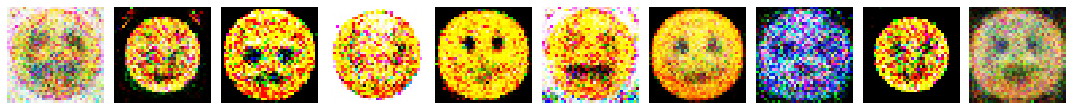

In [29]:
plot_generated_images(epochs, generator)

(-0.5, 35.5, 35.5, -0.5)

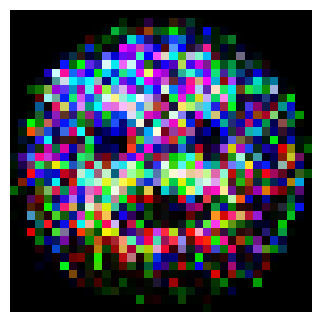

In [33]:
noise = np.random.normal(0, 1, size=[1, random_dim])
x = generator.predict(noise)
fig = plt.figure(dpi=100)
ax = fig.gca()
ax.imshow((x.reshape(36, 36, 3) * 255).astype(np.uint8), interpolation='nearest')
ax.axis('off')


In [ ]:
# fig.savefig('gan_disappoint.jpg', format='jpg')